In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform 

In [2]:
df = pd.read_csv('../dataset/mental_health_score_prediction.csv')
df.head()

,age,gender,daily_screen_time_hours,social_media_hours,sleep_duration_hours,sleep_quality,mood_rating,stress_level,physical_activity_hours_per_week,eats_healthy,caffeine_intake_mg_per_day,gaming_hours,mental_health_score
0,51,0,4.8,4.1,6.6,6,6,10,0.7,1,125.2,1.7,32
1,64,1,3.9,2.7,4.5,7,5,6,4.3,1,150.4,1.5,75
2,41,2,10.5,3.0,7.1,9,5,5,3.1,0,187.9,1.7,22
3,27,2,8.8,3.3,5.1,9,10,5,0.0,1,73.6,0.4,22
4,55,1,5.9,1.1,7.4,2,8,7,3.0,1,217.5,0.8,64


In [16]:
feature_columns = [
    'daily_screen_time_hours',
    'social_media_hours',
    'sleep_duration_hours',
    'sleep_quality',
    'mood_rating',
    'stress_level',
    'physical_activity_hours_per_week',
    'eats_healthy',
    'caffeine_intake_mg_per_day',
    'gaming_hours', 
]
target_column = 'mental_health_score'

X = df[feature_columns]
y = df[target_column]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nSelected Features:")
print(feature_columns)

Features (X) shape: (2000, 10)
Target (y) shape: (2000,)

Selected Features:
['daily_screen_time_hours', 'social_media_hours', 'sleep_duration_hours', 'sleep_quality', 'mood_rating', 'stress_level', 'physical_activity_hours_per_week', 'eats_healthy', 'caffeine_intake_mg_per_day', 'gaming_hours']


In [4]:
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

X_combined, X_test, y_combined, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
relative_val_ratio = val_ratio / (train_ratio + val_ratio)
X_train, X_val, y_train, y_val = train_test_split(X_combined, y_combined, test_size=relative_val_ratio, random_state=42)

print(f"Original data shape: {X.shape}")
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Original data shape: (2000, 4)
Train data shape: (1400, 4)
Validation data shape: (300, 4)
Test data shape: (300, 4)


In [5]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0], 
    'max_depth': [10, 20, 30, 40, 50, None], 
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10), 
    'bootstrap': [True, False]
}
print("Hyperparameter search space defined.")
print(param_dist)

Hyperparameter search space defined.
{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9981866850>, 'max_features': ['sqrt', 'log2', 0.6, 0.8, 1.0], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9981866990>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f9981867210>, 'bootstrap': [True, False]}


In [6]:
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random_search = RandomizedSearchCV(estimator=rf_base,
                                    param_distributions=param_dist,
                                    n_iter=50, 
                                    scoring='neg_mean_absolute_error',
                                    cv=5, 
                                    verbose=2, 
                                    random_state=42,
                                    n_jobs=-1) 

print("RandomizedSearchCV initialized. Starting search...")
rf_random_search.fit(X_train, y_train)

print("\nRandomized search complete.")
print("\nBest parameters found:")
print(rf_random_search.best_params_)
print("\nBest cross-validation MAE (from training set):")
print(-rf_random_search.best_score_) 

RandomizedSearchCV initialized. Starting search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Randomized search complete.

Best parameters found:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 17, 'n_estimators': 307}

Best cross-validation MAE (from training set):
15.504222561783541


In [7]:
best_rf_model = rf_random_search.best_estimator_

print("Evaluating the best model on the validation set...")

y_pred_val = best_rf_model.predict(X_val)

mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print(f"\n--- Model Evaluation on Validation Set (after tuning) ---")
print(f"Mean Absolute Error (MAE) on Val: {mae_val:.2f}")
print(f"Root Mean Squared Error (RMSE) on Val: {rmse_val:.2f}")
print(f"R-squared (R2) on Val: {r2_val:.2f}")
print("----------------------------------------------------------")

print("\nInterpretation on Validation Set:")
print("This gives us an estimate of how the tuned model performs on data it did not train on and that was not used in the internal cross-validation of the tuning process.")

Evaluating the best model on the validation set...

--- Model Evaluation on Validation Set (after tuning) ---
Mean Absolute Error (MAE) on Val: 14.66
Root Mean Squared Error (RMSE) on Val: 17.40
R-squared (R2) on Val: -0.01
----------------------------------------------------------

Interpretation on Validation Set:
This gives us an estimate of how the tuned model performs on data it did not train on and that was not used in the internal cross-validation of the tuning process.


In [8]:
print("Performing final evaluation on the TEST set...")
y_pred_test = best_rf_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"\n--- FINAL Model Evaluation on TEST Set ---")
print(f"Mean Absolute Error (MAE) on Test: {mae_test:.2f}")
print(f"Root Mean Squared Error (RMSE) on Test: {rmse_test:.2f}")
print(f"R-squared (R2) on Test: {r2_test:.2f}")
print("------------------------------------------")

print("\nFirst 10 Test Predictions vs Actual:")
for i in range(10):
    print(f"Actual: {y_test.iloc[i]:.2f}, Predicted: {y_pred_test[i]:.2f}")

Performing final evaluation on the TEST set...

--- FINAL Model Evaluation on TEST Set ---
Mean Absolute Error (MAE) on Test: 15.15
Root Mean Squared Error (RMSE) on Test: 17.66
R-squared (R2) on Test: -0.02
------------------------------------------

First 10 Test Predictions vs Actual:
Actual: 65.00, Predicted: 54.90
Actual: 62.00, Predicted: 52.06
Actual: 20.00, Predicted: 47.95
Actual: 35.00, Predicted: 48.89
Actual: 75.00, Predicted: 47.86
Actual: 23.00, Predicted: 47.52
Actual: 51.00, Predicted: 45.66
Actual: 60.00, Predicted: 51.15
Actual: 75.00, Predicted: 51.67
Actual: 21.00, Predicted: 52.90


In [9]:
print("\n--- Interpretation and Next Steps ---")
print("Evaluation on the TEST set provides the most reliable estimate of how the model will perform on truly new, unseen data.")
print(f"The final MAE of {mae_test:.2f} means the model's predictions are typically off by about {mae_test:.2f} points on the 1-100 mental health score scale.")
print(f"The final RMSE of {rmse_test:.2f} is slightly higher than MAE, indicating that larger errors are present and contribute more to the squared error.")
print(f"The final R-squared of {r2_test:.2f} indicates that approximately {r2_test*100:.1f}% of the variance in the mental health score can be explained by the features using this tuned Random Forest model.")

print("\nHow good is this? This depends heavily on the practical requirements of the mental wellness companion app.")
print(f"An average error of {mae_test:.2f} on a 1-100 scale might be acceptable depending on the sensitivity required.")

print("\nPossible Further Steps:")
print("1. Feature Importance: Examine the feature importances from the best model to understand which lifestyle factors are most predictive of the mental health score.")
print("2. Error Analysis: Dig deeper into specific predictions where the error is large to identify potential patterns or data issues.")
print("3. Explore Other Algorithms: Train and tune other regression models (e.g., Gradient Boosting like XGBoost/LightGBM, SVM, Neural Networks) and compare their performance on the validation set.")
print("4. Data Collection/Quality: If performance is not sufficient, consider if more data or higher quality data could improve the model.")
print("5. Model Explainability: Beyond feature importance, techniques like SHAP or LIME could offer deeper insights into individual predictions.")
print("6. Deployment: Plan for how the trained model will be used in the application, including necessary infrastructure and performance considerations.")

print("\nWe now have a tuned Random Forest model and an estimate of its performance on unseen data.")
print("Let me know if you'd like to delve into feature importance, error analysis, or explore alternative models!")


--- Interpretation and Next Steps ---
Evaluation on the TEST set provides the most reliable estimate of how the model will perform on truly new, unseen data.
The final MAE of 15.15 means the model's predictions are typically off by about 15.15 points on the 1-100 mental health score scale.
The final RMSE of 17.66 is slightly higher than MAE, indicating that larger errors are present and contribute more to the squared error.
The final R-squared of -0.02 indicates that approximately -2.3% of the variance in the mental health score can be explained by the features using this tuned Random Forest model.

How good is this? This depends heavily on the practical requirements of the mental wellness companion app.
An average error of 15.15 on a 1-100 scale might be acceptable depending on the sensitivity required.

Possible Further Steps:
1. Feature Importance: Examine the feature importances from the best model to understand which lifestyle factors are most predictive of the mental health scor

Calculating Feature Importances...

--- Feature Importances (Sorted) ---
caffeine_intake_mg_per_day          0.307136
physical_activity_hours_per_week    0.236154
sleep_duration_hours                0.229401
daily_screen_time_hours             0.227310
dtype: float64
------------------------------------


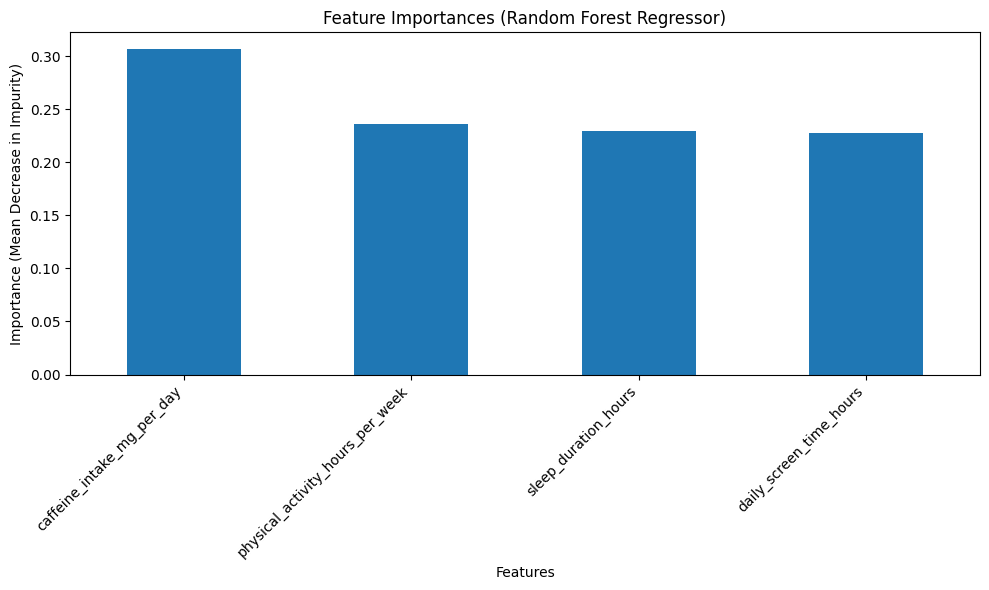


Interpretation of Feature Importance:
The bar chart and the sorted list show the relative importance of each feature.
Features with higher values contributed more to reducing error in the model across the trees.
This suggests these are the most influential factors in predicting mental health scores based on this dataset and model.

Keep in mind:
- This is model-specific importance (for this particular Random Forest model). Other models might rank features differently.
- This metric (MDI) can sometimes be slightly biased towards features with more unique values or categories.
- Correlation between features can also affect perceived importance.


In [10]:
import matplotlib.pyplot as plt 
print("Calculating Feature Importances...")
importances = best_rf_model.feature_importances_

feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names)
sorted_feature_importance = feature_importance_series.sort_values(ascending=False)
print(sorted_feature_importance)

plt.figure(figsize=(10, 6))
sorted_feature_importance.plot(kind='bar')
plt.title('Feature Importances (Random Forest Regressor)')
plt.ylabel('Importance (Mean Decrease in Impurity)')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Analyzing the distribution of the target variable (mental_health_score)...


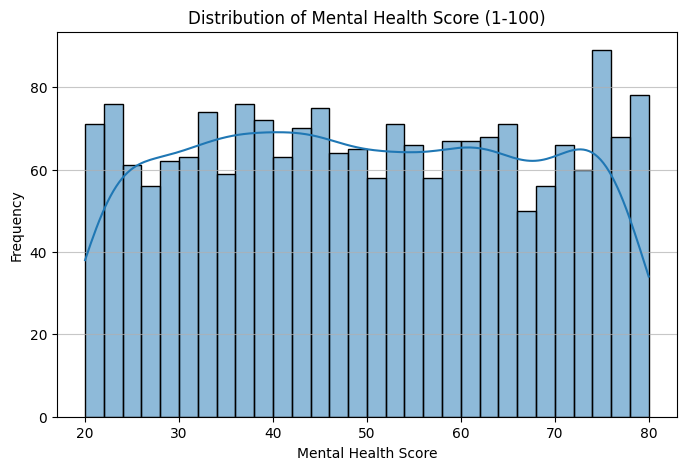


Target variable descriptive statistics:
count    2000.000000
mean       49.650500
std        17.546717
min        20.000000
25%        35.000000
50%        49.000000
75%        64.250000
max        80.000000
Name: mental_health_score, dtype: float64


In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df['mental_health_score'], kde=True, bins=30)
plt.title('Distribution of Mental Health Score (1-100)')
plt.xlabel('Mental Health Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.7)
plt.show()

Analyzing the distribution of individual features...


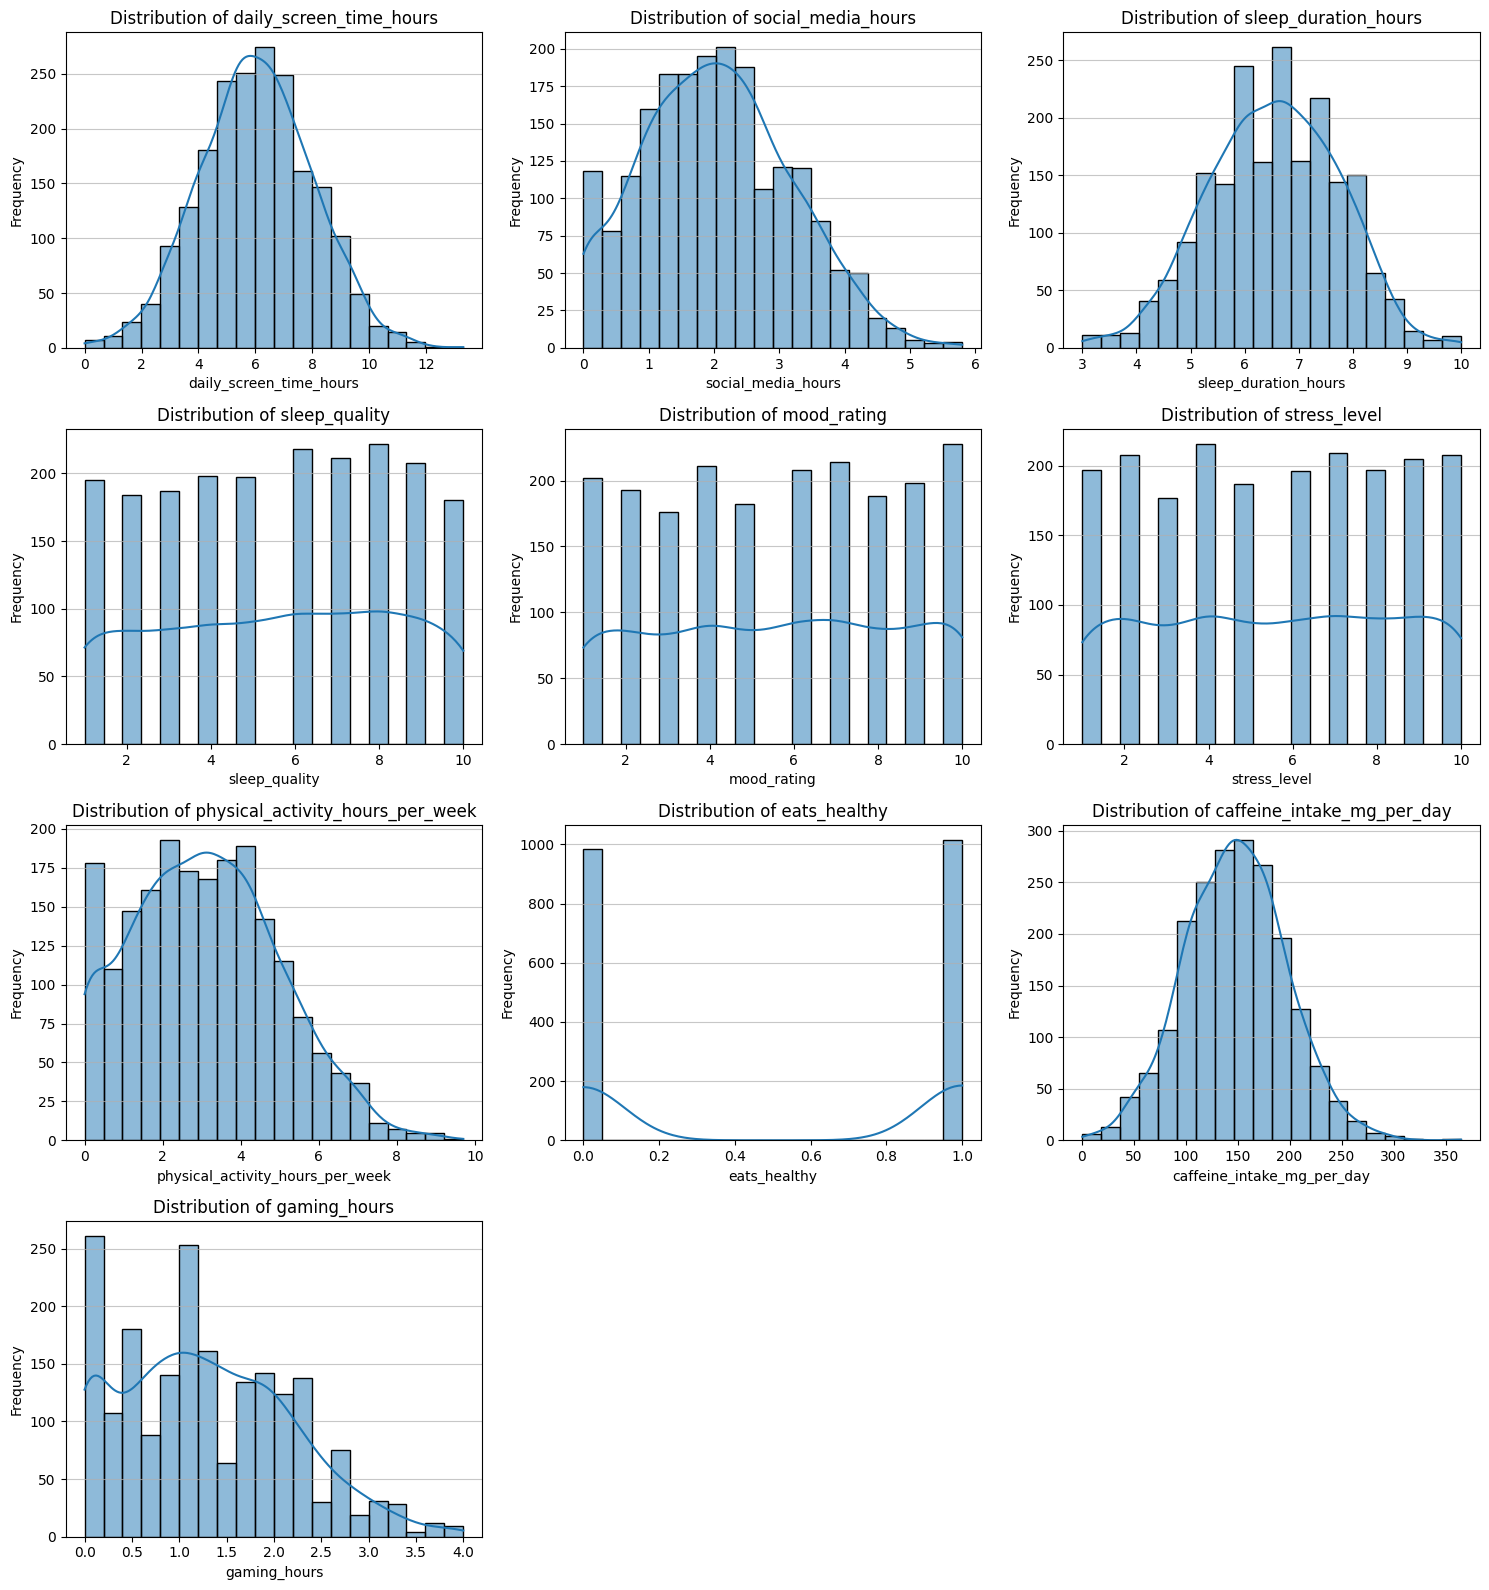

In [18]:
X_subset = df[feature_columns]
n_features = len(feature_columns)
n_cols = 3 
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(X_subset.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(X_subset[col], kde=True, bins=20) 
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.7)

plt.tight_layout()
plt.show()

Calculating and visualizing the correlation matrix...


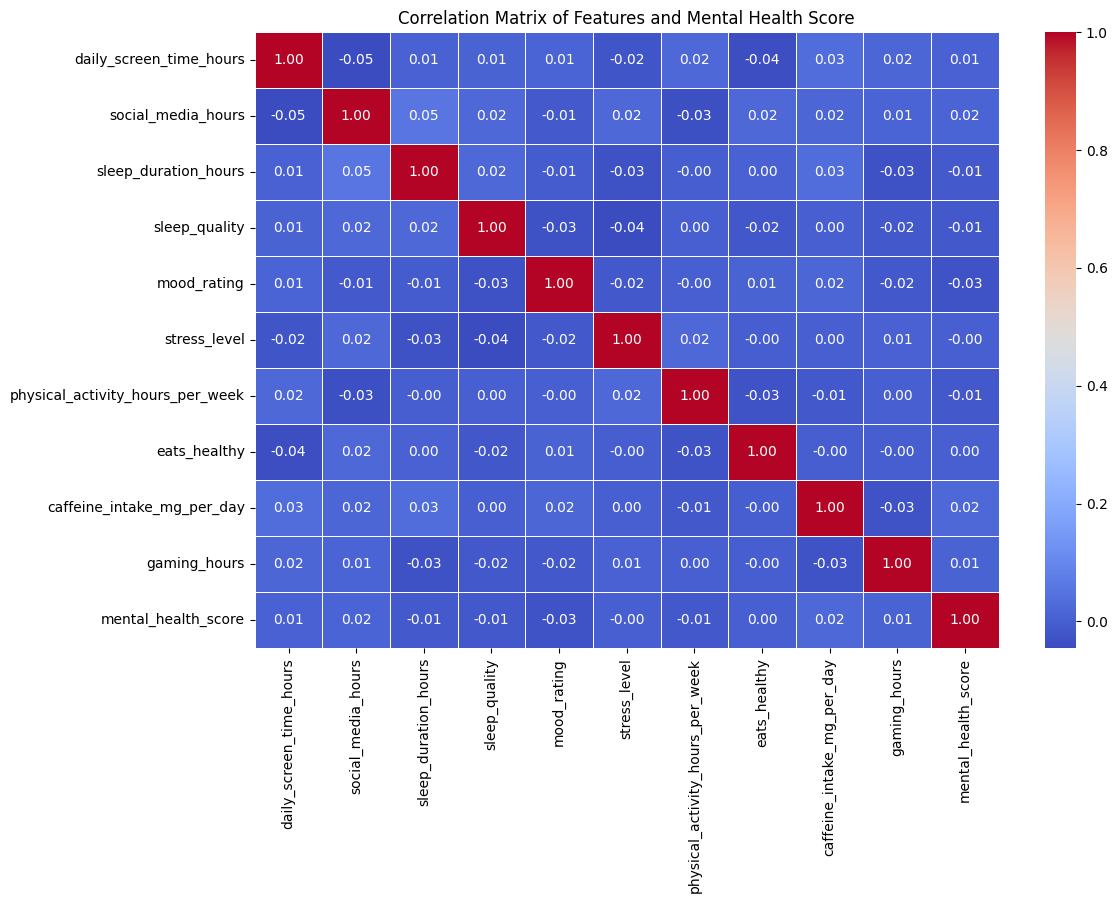

In [20]:
# Cell 13: Correlation Matrix

print("Calculating and visualizing the correlation matrix...")

# Include the target variable in the correlation calculation
df_corr = df[feature_columns + [target_column]].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features and Mental Health Score')
plt.show()


Visualizing relationships between ordinal/categorical features and the target variable...


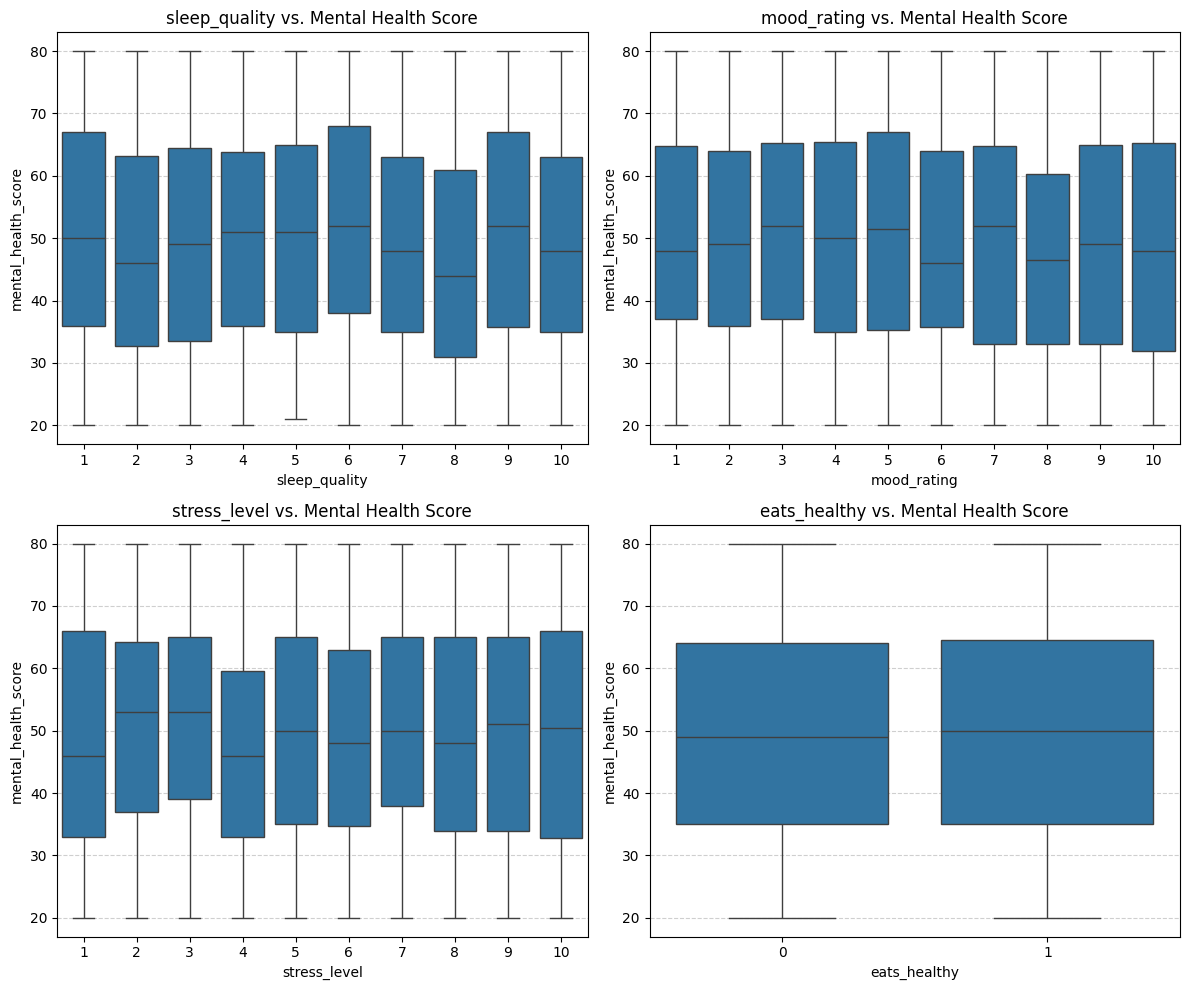

In [19]:
ordinal_features = ['sleep_quality', 'mood_rating', 'stress_level', 'eats_healthy']
ordinal_features = [f for f in ordinal_features if f in feature_columns]

if ordinal_features:
    n_features_ord = len(ordinal_features)
    n_cols_ord = 2
    n_rows_ord = (n_features_ord + n_cols_ord - 1) // n_cols_ord

    plt.figure(figsize=(n_cols_ord * 6, n_rows_ord * 5)) 

    for i, col in enumerate(ordinal_features):
        plt.subplot(n_rows_ord, n_cols_ord, i + 1)
        sns.boxplot(data=df, x=col, y=target_column, order=sorted(df[col].unique()))
        plt.title(f'{col} vs. Mental Health Score')
        plt.xlabel(col)
        plt.ylabel(target_column)
        plt.grid(axis='y', linestyle='--', alpha=0.6)


    plt.tight_layout()
    plt.show()